# Project Work - IRM24
## Jürgen Aumayr & Natalia Trudova

### Decision Trees

### Datenimport und Vorverarbeitung

Der erste Codeblock ist für den Import der notwendigen Bibliotheken und das Laden der Daten zuständig.

In [1]:
# Notwendige Bibliotheken importieren - nur die tatsächlich benötigten für bessere Ladezeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Optimierte Datentypen definieren, um Speicherverbrauch zu reduzieren
dtypes = {
    'PassengerId': 'int32',  # 32-bit Integer für IDs ist ausreichend
    'Survived': 'int8',      # 8-bit Integer für binäre Werte (0/1)
    'Pclass': 'int8',        # 8-bit Integer für kleine Kategorien (1-3)
    'Name': 'str',           # String für Namen
    'Sex': 'category',       # Kategorie-Typ für höhere Effizienz bei wiederholten Werten
    'Age': 'float32',        # 32-bit Float statt Standard 64-bit
    'SibSp': 'int8',         # 8-bit Integer für kleine Zahlen
    'Parch': 'int8',         # 8-bit Integer für kleine Zahlen
    'Ticket': 'str',         # String für Ticketnummern
    'Fare': 'float32',       # 32-bit Float für Fahrpreise
    'Cabin': 'str',          # String für Kabinennummern
    'Embarked': 'category'   # Kategorie-Typ für Einschiffungshäfen (S, C, Q)
}

# Daten mit optimierten Datentypen einlesen zur Speicherreduktion
train_df = pd.read_csv('data/train.csv', dtype=dtypes)

# Passagier-IDs für spätere Referenz speichern
train_ids = train_df['PassengerId'].copy()

# Ersten drei Zeilen der Originaldaten zur Übersicht anzeigen
display(train_df.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S


### Feature Engineering

Hier werden neue Features erstellt und bestehende transformiert:

* 'Sex' wird in numerische Werte umgewandelt (0 für weiblich, 1 für männlich).
* 'Age' wird in Kategorien eingeteilt (1: 0-18, 2: 19-60, 3: 61+).
* 'Fare' wird in Quartile eingeteilt (0-3).
* 'Embarked' wird in numerische Werte umgewandelt.
* 'Has_Cabin' wird als binäres Feature erstellt.
* 'FamilySize' und 'IsAlone' werden aus 'SibSp' und 'Parch' berechnet.
* 'Title' wird aus dem 'Name' extrahiert und kategorisiert.

In [2]:
def preprocess_features(df):
    """
    Bereitet die Titanic-Daten für das Modelltraining vor und
    erzeugt optimierte Features aus den Rohdaten.
    """
    # Kopie erstellen, um Originaldaten nicht zu verändern
    dataset = df.copy()
    
    # Geschlecht in numerisch konvertieren
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
    
    # Fehlende Alterswerte mit Median füllen - nach Klasse und Geschlecht gruppiert
    age_median = dataset.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    dataset['Age'] = dataset['Age'].fillna(age_median)

    # NaN-Werte durch den Median ersetzen
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    
    # Alter in Kategorien einteilen
    dataset['Age'] = pd.cut(
        dataset['Age'], 
        bins=[0, 18, 60, np.inf], 
        labels=[1, 2, 3]
    ).astype('int8')
    
    # Fahrpreise in Quartile einteilen für bessere Vergleichbarkeit
    dataset['Fare'] = pd.qcut(
        dataset['Fare'], 
        q=4, 
        labels=[0, 1, 2, 3],
        duplicates='drop'  # Verhindert Fehler bei doppelten Grenzwerten
    ).astype('int8')
    
    # Einschiffungshafen in numerische Werte umwandeln
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype('int8')
    
    # Binäres Merkmal: Hat der Passagier eine Kabinennummer oder nicht?
    dataset['Has_Cabin'] = (dataset['Cabin'].notna()).astype('int8')
    
    # Berechnung der Familiengröße und Alleinreisenden-Status
    dataset['FamilySize'] = (dataset['SibSp'] + dataset['Parch'] + 1).astype('int8')
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype('int8')
    
    # Titel aus Namen extrahieren mit regulärem Ausdruck - effizienter als Split
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Titel-Mapping für Kategorisierung
    title_mapping = {
        "Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5
    }
    
    # Seltenere Titel zusammenfassen, um Overfitting zu vermeiden
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Mlle', 'Mme', 'Ms']
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title'] = dataset['Title'].map(title_mapping).fillna(5).astype('int8')
    
    return dataset

# Daten vorverarbeiten und relevante Features auswählen
processed_df = preprocess_features(train_df)
features_df = processed_df[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 
                            'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 
                            'IsAlone', 'Title']]

# Vorverarbeitete Features anzeigen
display(features_df.head(3))

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,2,0,1,0,0,1,1,4


### Statistische Analyse der Features

Diese Analysen geben Einblicke in die Zusammenhänge zwischen verschiedenen Features und der Überlebenswahrscheinlichkeit.

* Überlebensstatistiken nach Titel:
    Zeigt den Mittelwert, die Anzahl und die Summe der Überlebenden für jeden Titel.
* Überlebensstatistiken nach Geschlecht:
    Präsentiert ähnliche Statistiken, aber aufgeschlüsselt nach Geschlecht.
* Kreuztabelle für Geschlechtsverteilung nach Titel:
    Zeigt den Anteil von Männern und Frauen für jeden Titel.

In [3]:
# Überlebensstatistiken nach Titel gruppiert - effizient mit .agg()
title_stats = processed_df.groupby('Title')['Survived'].agg(['mean', 'count', 'sum'])
display(title_stats)

# Überlebensstatistiken nach Geschlecht
sex_stats = processed_df.groupby('Sex')['Survived'].agg(['mean', 'count', 'sum'])
display(sex_stats)

# Kreuztabelle für Geschlecht-Verteilung nach Titel
# Verwendet eine effiziente Methode zur Erzeugung der Kreuztabelle
title_sex_cross = pd.crosstab(
    index=processed_df['Title'],
    columns=processed_df['Sex'],
    normalize='index'
)

display(title_sex_cross)

,mean,count,sum
Title,,,
1,0.156673,517,81
2,0.575000,40,23
3,0.792000,125,99
4,0.697802,182,127
5,0.444444,27,12


,mean,count,sum
Sex,,,
0,0.742038,314,233.0
1,0.188908,577,109.0


Sex,0,1
Title,,
1,0.000000,1.000000
2,0.000000,1.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.259259,0.740741


Erklärung: Geschlecht: 'female': 0, 'male': 1
           Titel:      'Mr': 1, 'Master': 2, 'Mrs': 3, 'Miss': 4, 'Rare': 5

### Modelltraining und Hyperparameter-Optimierung

Die Verwendung von GridSearchCV für die automatische Hyperparameter-Optimierung verbessert die Modellperformance erheblich. Die Parallelisierung durch n_jobs=-1 beschleunigt den Suchprozess durch Nutzung aller verfügbaren CPU-Kerne. Die stratifizierte Stichprobe sorgt für eine ausgewogene Klassenverteilung in den Trainings- und Testdaten.

In [44]:
# Features und Zielvariable trennen
X = features_df.drop('Survived', axis=1)
y = features_df['Survived']

# Daten in Trainings- und Validierungssets aufteilen mit stratifizierter Stichprobe
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter-Grid für automatische Optimierung
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Parallelisierte Suche mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,  # Nutzt alle verfügbaren CPU-Kerne
    scoring='accuracy'
)

# Modell trainieren
grid_search.fit(X_train, y_train)

# Beste Parameter und Ergebnis anzeigen
print(f"Beste Parameter: {grid_search.best_params_}")
print(f"Beste Kreuzvalidierungs-Genauigkeit: {grid_search.best_score_:.4f}")

# Bestes Modell auf Validierungsdaten bewerten
best_model = grid_search.best_estimator_
val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Validierungs-Genauigkeit: {val_accuracy:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_val, val_pred))

"Beste Parameter: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}"

Beste Kreuzvalidierungs-Genauigkeit: 0.8315
Validierungs-Genauigkeit: 0.7933

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



### Visualisierung des Decision Trees

Die Visualisierung wurde mit einer begrenzten Baumtiefe für bessere Lesbarkeit optimiert. Die Verwendung von tight_layout() und die hochauflösende Speicherung verbessern die Qualität der Grafik. Das horizontale Balkendiagramm für Feature-Wichtigkeit ist bei vielen Features besser lesbar als ein vertikales.

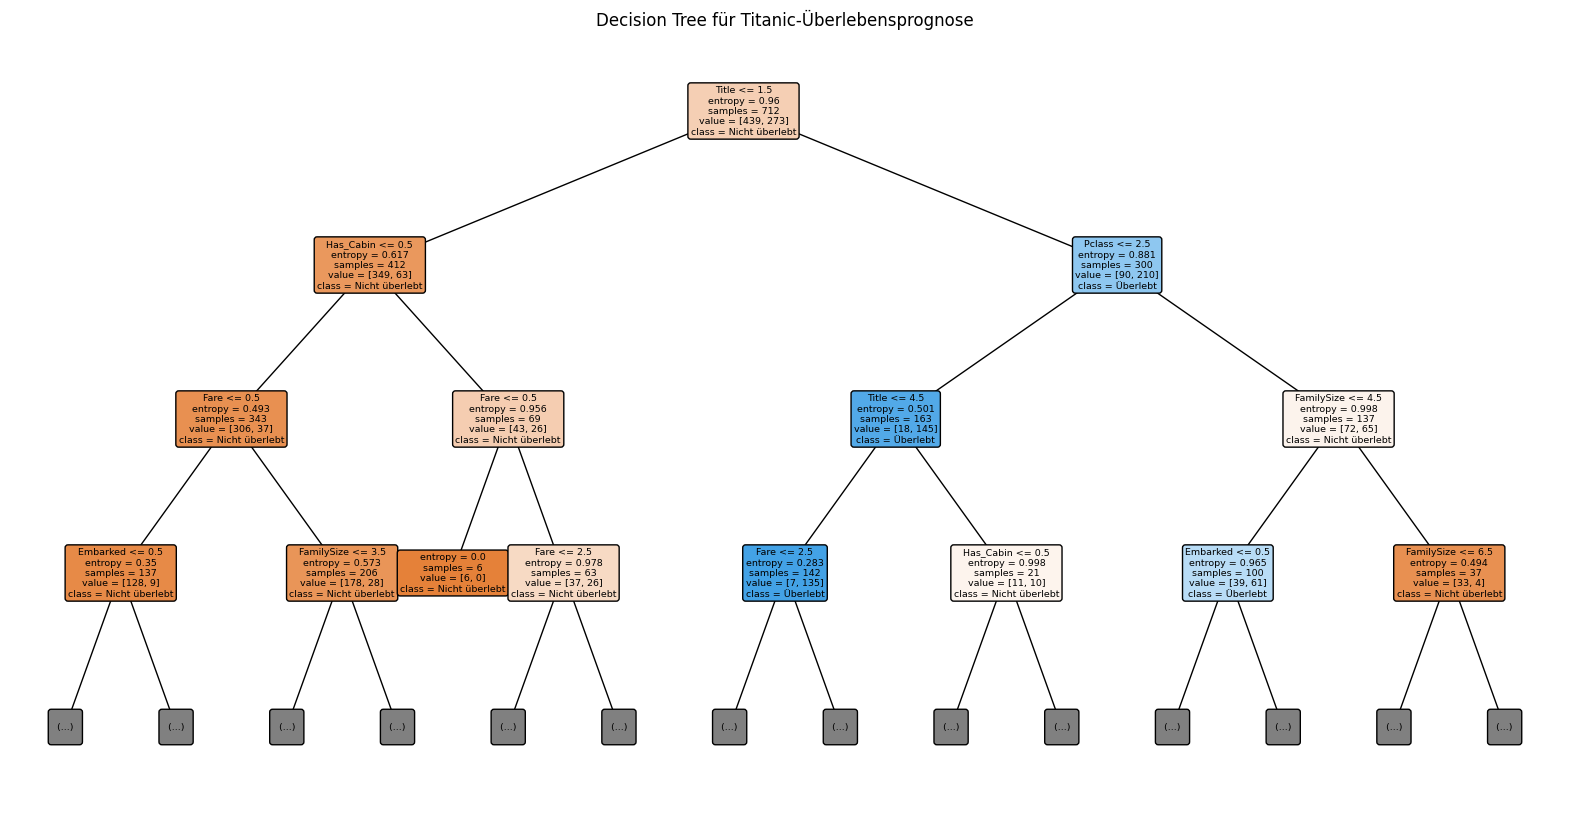

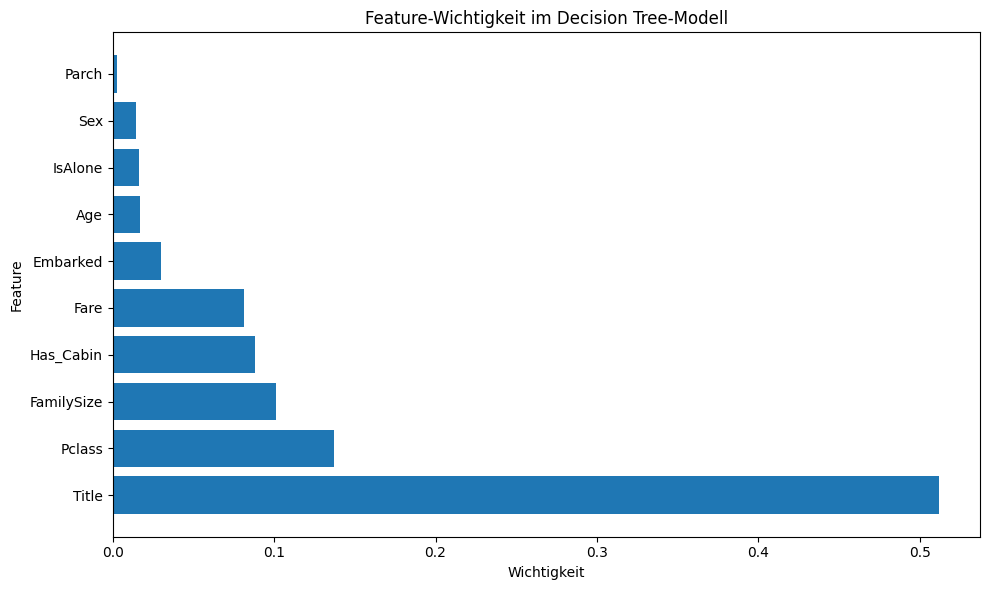

In [25]:
# Visualisierung des optimierten Decision Trees
plt.figure(figsize=(20, 10))
plot_tree(
    best_model, 
    filled=True, 
    feature_names=X.columns,
    class_names=['Nicht überlebt', 'Überlebt'],
    rounded=True,
    max_depth=3  # Begrenzte Tiefe für bessere Lesbarkeit
)

plt.title('Decision Tree für Titanic-Überlebensprognose')
plt.savefig('decision_tree.png')  # Hochauflösende Speicherung
plt.show()

# Feature-Wichtigkeit analysieren
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Horizontales Balkendiagramm für bessere Lesbarkeit bei vielen Features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature-Wichtigkeit im Decision Tree-Modell')
plt.tight_layout()
plt.show()


### Vorhersage und Ergebnisexport

Der Code zum Exportieren vermeidet unnötige Indexspalten. Die abschließende Zusammenfassung gibt einen schnellen Überblick über die Verteilung der Vorhersagen.

,PassengerId,Name,Sex,Survived
0,892,"Kelly, Mr. James",male,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",female,0
2,894,"Myles, Mr. Thomas Francis",male,0
3,895,"Wirz, Mr. Albert",male,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,0
5,897,"Svensson, Mr. Johan Cervin",male,0
6,898,"Connolly, Miss. Kate",female,1
7,899,"Caldwell, Mr. Albert Francis",male,0
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1
9,901,"Davies, Mr. John Samuel",male,0


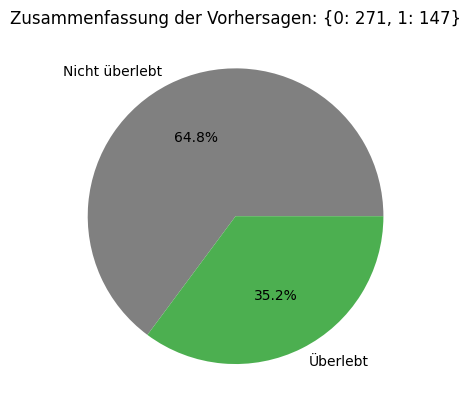

In [48]:
# Test-Daten laden und vorverarbeiten
test_df = pd.read_csv('data/test.csv', dtype=dtypes)
test_processed = preprocess_features(test_df)

# Relevante Features auswählen
X_test = test_processed[X.columns]

# Vorhersagen mit dem optimierten Modell
test_predictions = best_model.predict(X_test)

# Ergebnisse für Einreichung vorbereiten
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Name': test_df['Name'],
    'Sex': test_df['Sex'],
    'Survived': test_predictions
})

# Optimierte CSV-Speicherung ohne Indexspalte und mit effizienter Kompression
submission.to_csv('submission.csv', index=False, encoding='utf-8')

# Anzeigen der ersten Datensätze der Vorhersage
display(submission.head(10))

# Erstelle Pie Chart zur Visualiserung der Vorhersage
survivors = submission['Survived'].value_counts().to_dict()
piechart = np.array([survivors.get(0), survivors.get(1)])
survlabels = ["Nicht überlebt", "Überlebt"]
survcolors = ["grey", "#4CAF50"]
plt.title(f"Zusammenfassung der Vorhersagen: {submission['Survived'].value_counts().to_dict()}")
plt.pie(piechart, labels = survlabels, colors = survcolors, autopct='%1.1f%%')
plt.show() 